# Getting Started with Interactive Mapping and Data Visualization
#### Prepared for 2021 GIS Day Workshop by Zhiyu Li

## Programming with CyberGIS-Jupyter

- **Cell**
 - Add a cell: single click on a cell --> Menu --> Insert
 - Delete a cell: single click on the cell to delete --> Menu --> Edit --> Delete Cells
 - Reorder a cell: click on a cell --> up arrow or down arrow
 - Change cell type: single click on a cell ---> Menu --> Cell Type
 - Edit cell
   - Markdown: double click   ([basic syntax reference](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html))
   - Code: single click  
 - Run a cell: single click on a cell --> Run (or Shift + Enter)
 - Run all cells: Menu --> Cell --> Run All
 - Clear all cell output: Menu --> Cell --> All Output --> Clear
- **Kernel**
 - Change kernel: Menu --> Kernel --> Change kernel
   - Choose versioned kernel (eg XXXXX-0.8.0) before sharing
 - Restart kernel: Menu --> Kernel --> Restart (& Clear output)
- **See all notebooks (Tree View) on CyberGIS-Jupyter**
 - On CyberGIS-Hub page: click on "Launch CyberGISX" at the upper-right corner
 - On an opened notebook page: remove notebook filename (XXXX.ipynb) from browser address bar 
- **Troubleshooting**
 - Restart kernel
 - Restart CyberGIS-Jupyter (save notebook first!): Control Panel --> Stop My Server --> Start Server
 - Bug Report button
 - Announcement area (maintenance plan, release notes)
- **More Info**
 - ["Getting Started" series notebooks on CyberGISX](https://cybergisxhub.cigi.illinois.edu/notebooks/)
 - ["Jupyter Notbooks" section in Knowledge Base](https://cybergisxhub.cigi.illinois.edu/knowledge-base/)
- **Try it out now**

#### Task 1: Add one new code cell after this cell
Hint: Single click on this cell --> go to Menu --> Insert --> Insert Cell Below

**Task 2: Change the new cell's type to Markdown, and write something in it**

Hint: Single click on the new cell --> go to Menu --> Cell --> Cell Type --> Markdown; Single click on the new cell ---> write some Markdowns see [basic syntax reference](https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Working%20With%20Markdown%20Cells.html)

#### Task 3: Uncomment the Python codes in the cell  below and run it
Hint: Single click on the cell below --> Remove the Pound sign ('#') --> press Shift + Enter keys together

In [1]:
#print("hello world")

#### Task 4: clean all output of this notebook
Hint: go to Menu --> Cell --> All Output --> Clear

##### ------------- Below is the main section of the Mapping and Visualization notebok -----------------

<a id='intro'></a>
## Introduction
This notebook will walk you through some basic techniques of conducting <b>Interative Mapping and Data Visualization</b> in the CyberGIS-Jupyter environment. We will retrieve the latest COVID-19 data from the [Illinois Department of Public Health](https://dph.illinois.gov/covid19/data/data-portal.html) (IDPH) website, examine and preprocess the data, make plots of daily new cases by counties using [matplotlib](https://matplotlib.org/), create an interactive map with [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/) to visualize weekly channge of new cases across the state, and finally link map and plot together. 

After finishing this notebook, you will have a "app-style" notebook like the screenshot below. You are encouraged to tweak the codes a little bit to visualize other COVID-19 indices, such as deaths and testings. 

<img src="https://github.com/cybergis/GISDay_workshop_2021/raw/main/statics/screen.gif" width="750" align="center">

## Notebook Outline:
- [Introduction](#intro)
- [Setup](#setup)
- [Data retrieval and preprocessing](#data_processing)
    - [Download data from IDPH website](#download_data)
    - [Examine raw data](examine_data)
- [Plot time series data for a county](#time_series)
- [Visualize weekly change of new cases at county level across the state](#visualize_weekly_change_rate)
    - [Calcuate weekly change rate](#calculate_weekly_change_rate)
    - [Data classification and Colormap](#data_classification)
    - [Create a Choropleth Map with ipyLeaflet](#choropleth_map)
- [App-style Interactive Map](#app_style_map)

<a id='setup'></a>
## Setup
This cell is to import required modules and libs. A breif description on the purpose of each libs can be found below:

 - [json](https://docs.python.org/3/library/json.html) - standard Python module for JSON format I/O operations
 - [wget]() - for downloading files from URLs
 - [numpy](https://numpy.org/) - for handling N-dimentional arrays and numerical computing
 - [pandas](https://pandas.pydata.org/) - for tabular data analysis and manipulation
 - [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/) - for interactive mapping in Jupyter Notebook environment
 - [branca](https://python-visualization.github.io/branca/colormap.html) - for dealing with colormaps
 - [matplotlib]() - for creating plots and figures 

In [2]:
import json
import wget
import numpy as np
import pandas as pd
import geopandas as gpd
import ipyleaflet
from branca import colormap
import matplotlib.pyplot as plt

# for interactive charting
%matplotlib notebook

<a id='data_processing'></a>
## Data retrieval and preprocessing

The [Illinois Department of Public Health](https://dph.illinois.gov/) has a [COVID-19 data portal](https://dph.illinois.gov/covid19/data/data-portal.html) that provides different metrics and data, including "county-level histrorical cases, deaths and tested", "hospitalization data", "vaccine administration data", "zipcode-level cases and tested data" and others. As noted on the website, data avaialbility, update frequency, data format and metrics reported are subject to change.

The next cell will programmatically download the latest "county-level histrorical cases, deaths and tested" data on the fly. Since IDPH may choose to stop updating or remove the data from their website in the future, we downloaded the data as of Nov 16, 2021 and saved it (filename: idph_counties_Nov16_2021.csv) alongside the notebook for archive.

<a id='download_data'></a>
### Download data from IDPH website

In [3]:
# Download the latest data from IDPH website
# https://dph.illinois.gov/covid19/data/data-portal/all-county-historical-snapshot.html
idph_counties_url = "https://idph.illinois.gov/DPHPublicInformation/api/COVIDExport/GetSnapshotHistorical?format=csv"
idph_counties_csv = wget.download(idph_counties_url, out="./idph_counties.csv")

## If you see any error in this cell, that probably indicates IDPH has removed this data from their website
## You can continute with this notebook using an archived data by uncommenting the following line and re-run this cell
#idph_counties_csv = "idph_counties_Nov10_2021.csv"

print("Using data at {}".format(idph_counties_csv))

Using data at ./idph_counties.csv


<a id='examine_data'></a>
### Examine raw data
The raw data is a csv file. We load it into a pandas dataframe (the 1st row is ignored as it is the title line). 

In [4]:
df = pd.read_csv(idph_counties_csv, skiprows=1, parse_dates=['ReportDate'])
df

,CountyName,CumulativeCases,CasesChange,TotalTested,TotalTestedChange,Deaths,DeathsChange,ReportDate
0,Adams,0,0,0,0,0,0,2020-03-17
1,Alexander,0,0,0,0,0,0,2020-03-17
2,Bond,0,0,0,0,0,0,2020-03-17
3,Boone,0,0,0,0,0,0,2020-03-17
4,Brown,0,0,0,0,0,0,2020-03-17
...,...,...,...,...,...,...,...,...
63435,Whiteside,8680,27,122618,283,188,0,2021-11-16
63436,Will,95510,201,1590208,3561,1151,2,2021-11-16
63437,Williamson,12375,12,179707,356,181,0,2021-11-16
63438,Winnebago,44345,121,651933,1449,576,1,2021-11-16


Each row includes metrics of a specific county reported on a specific day. We can see the earliest data is from 2020-03-17 and the rows at the bottom are the most recent data.

![Weekly Change Rate](statics/raw_data.png)

List all county names. Note that IDPH separates Chicago city area from from Cook county in this dataset, and it treats Chicago as standalone county.

In [5]:
df.CountyName.unique()

array(['Adams', 'Alexander', 'Bond', 'Boone', 'Brown', 'Bureau',
       'Calhoun', 'Carroll', 'Cass', 'Champaign', 'Chicago', 'Christian',
       'Clark', 'Clay', 'Clinton', 'Coles', 'Cook', 'Crawford',
       'Cumberland', 'De Witt', 'DeKalb', 'Douglas', 'DuPage', 'Edgar',
       'Edwards', 'Effingham', 'Fayette', 'Ford', 'Franklin', 'Fulton',
       'Gallatin', 'Greene', 'Grundy', 'Hamilton', 'Hancock', 'Hardin',
       'Henderson', 'Henry', 'Illinois', 'Iroquois', 'Jackson', 'Jasper',
       'Jefferson', 'Jersey', 'Jo Daviess', 'Johnson', 'Kane', 'Kankakee',
       'Kendall', 'Knox', 'Lake', 'LaSalle', 'Lawrence', 'Lee',
       'Livingston', 'Logan', 'Macon', 'Macoupin', 'Madison', 'Marion',
       'Marshall', 'Mason', 'Massac', 'McDonough', 'McHenry', 'McLean',
       'Menard', 'Mercer', 'Monroe', 'Montgomery', 'Morgan', 'Moultrie',
       'Ogle', 'Peoria', 'Perry', 'Piatt', 'Pike', 'Pope', 'Pulaski',
       'Putnam', 'Randolph', 'Richland', 'Rock Island', 'Saline',
       'Sangamo

<a id='time_series'></a>
## Plot time series data for a county

We will plot the time series of daily new cases (metric/column name: "CasesChange") for a specific county you selected. You may change the county name or the metric/column name and re-run the following cells to visualiae a different plot of interest.

In [6]:
county_name = "Chicago" # pick a county from above and put it here
metric_name = "CasesChange" # which metric/column to plot, see the headers of the original dataframe

Here we extract data for the county selected.

In [7]:
one_county = df[df["CountyName"]==county_name].set_index("ReportDate")
one_county

,CountyName,CumulativeCases,CasesChange,TotalTested,TotalTestedChange,Deaths,DeathsChange
ReportDate,,,,,,,
2020-03-17,Chicago,0,0,0,0,0,0
2020-03-18,Chicago,0,0,0,0,0,0
2020-03-19,Chicago,0,0,0,0,0,0
2020-03-20,Chicago,0,0,0,0,0,0
2020-03-21,Chicago,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2021-11-12,Chicago,333272,606,7135323,34986,5941,0
2021-11-13,Chicago,333716,444,7161553,26230,5948,7
2021-11-14,Chicago,334225,509,7181137,19584,5948,0


Plot the selected metric/column ("CasesChange" by default). The plot is created with matplotlib. Pandas has build-in support for matplotlib so we can make a plot from a panda dataframe directly.

<IPython.core.display.Javascript object>


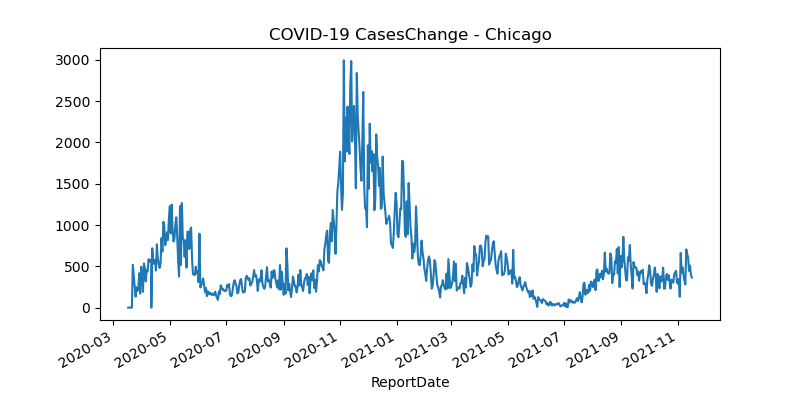

<AxesSubplot:title={'center':'COVID-19 CasesChange - Chicago'}, xlabel='ReportDate'>

In [8]:
fig1, ax1 = plt.subplots(1,1, figsize=(8,4))
title = 'COVID-19 {} - {}'.format(metric_name, county_name)
one_county[metric_name].plot(ax=ax1, title=title)

<a id='visualize_weekly_change_rate'></a>
## Visualize weekly change of new cases at county level across the state

In this section, we will create a [Choropleth Map](https://en.wikipedia.org/wiki/Choropleth_map) to visualize the weekly change of new cases at county level across all counties in the state. We will randomly pick a date (day0) as the starting point, and look back for 1 week and calculate the number of new cases reported for that week (cases_current_week). We then look back for another week and caculate the same metric (cases_last_week). The weekly change rate is (cases_current_week - cases_last_week)/cases_last_week * 100%, and is calculated county by county. If the resulting number is postive (or negative), that means we are getting more (or less) cases than last week. The magnitude shows how fast the situation is changing, and we will use different colors to repreent them on the map. There is an edge case: if no new cases reported for the last week (cases_last_week=0), the change rate will become infinity as the denominator is 0. The pandas dataframe is able to handle it. 

![Weekly Change Rate](statics/weekly_change_rate.png)

<a id='calculate_weekly_change_rate'></a>
### Calcuate weekly change rate
Here we pick a date as the day0 and extract "CumulativeCases" on that day for all counties. Be sure the date selected is within the range of the data and at least 2 weeks after the earilest reporting date (2020-03-27).

Here we calcuate number of new cases reported for current week (cases_current_week) and last week (cases_last_week).

In [9]:
day0 = np.datetime64('2021-11-16') # pick a date in the format of YYYY-MM-DD

# calculate new cases for this week
cum_cases_day0 = df[df["ReportDate"]==day0].set_index("CountyName").CumulativeCases
day_1week = day0 - np.timedelta64(1,'W')
cum_cases_1week = df[df["ReportDate"]==day_1week].set_index("CountyName").CumulativeCases
cases_current_week = cum_cases_day0.sub(cum_cases_1week)
# calculate new cases for last week
day_2week = day0 - np.timedelta64(2,'W')
cum_cases_2week = df[df["ReportDate"]==day_2week].set_index("CountyName").CumulativeCases
cases_last_week = cum_cases_1week.sub(cum_cases_2week)

pd.DataFrame({'Current Weel': cases_current_week,'Last Week':cases_last_week})

,Current Weel,Last Week
CountyName,,
Adams,256,160
Alexander,21,14
Bond,23,37
Boone,148,77
Brown,2,12
...,...,...
Whiteside,141,115
Will,1510,1068
Williamson,89,76


Calcuate weekly change rate for all counties, and sort them by the rates. You can check if any county has Postive Infinity.

In [10]:
weekly_change_rate = cases_current_week.sub(cases_last_week).div(cases_last_week)
weekly_change_rate.sort_values().to_frame("Change_Rate")

,Change_Rate
CountyName,
Brown,-0.833333
Hamilton,-0.666667
Pope,-0.666667
Henderson,-0.416667
Mason,-0.391304
...,...
Menard,1.259259
Stark,1.500000
Pike,1.526316


<a id='data_classification'></a>
### Data classification and Colormap

We have calculcated the weekly change rate for every county. To visualize them on the map, we need to classify this metric into several classes and assign each class a different color.

Here we classify the weekly change rate into 5 classes. Note that we are doing manual data classification and the breaks we chose are pretty arbitrary. How to do the data classifiation mainly depends on the data itself and how you want to represent them on the map. Sometimes trial and error might be needed to find the "best" classification. Also there are other more advanced methods and tools. See [Data Classification For Choropleth Maps](https://storymaps.arcgis.com/stories/871fe556c40b4d40b7a465c6f135ac88) and [MapClassify].(https://github.com/pysal/mapclassify) for details.

```
  > +50%      Class 1
+10% to +50%  Class 2   
-10% to +10%  Class 3            
-10% to -50%  Class 4       
  < -50%      Class 5                
```

In [11]:
# the function that maps weekly change rate values to class 1-5
def classify(v):
    if v > 0.5:            
        color_index = 1    #  class 1 - change rate > 50%
    elif v > 0.1:
        color_index = 2    #  class 2 - change rate 10% to 50%
    elif v > -0.1:
        color_index = 3    #  class 3 - change rate -10% to +10%
    elif v > -0.5:
        color_index = 4    #  class 4 - change rate -50% to +-10%
    else: # < -0.5
        color_index = 5    #  class 5 - change rate < -50%
    return color_index

Apply the above classify() function to every county in the "weekly chanage rate" dateframe. The resulting dataframe lists county names and assigned color indices.

In [12]:
weekly_change_rate_class = weekly_change_rate.apply(classify)
weekly_change_rate_class.to_frame("Class")

,Class
CountyName,
Adams,1
Alexander,2
Bond,4
Boone,1
Brown,5
...,...
Whiteside,2
Will,2
Williamson,2


Once the data is classified, we can pick colors for every class. The library [branca](https://python-visualization.github.io/branca/colormap.html) provides a large collection of prebuilt color ramps. Here we have picked a Red-Yellow-Green color ramp.  You may uncomment the following cell to see more avaiable color ramps.

In [13]:
#colormap.linear

In [14]:
cm_linear = colormap.linear.RdYlGn_08
cm_linear

We create 5 discrete color steps and assign class indices to them:

In [15]:
N_color_steps = 5  # How many discrete color steps
# The "cm" object (color map) is callable that takes a index and returns color code.
cm = cm_linear.to_step(index=range(N_color_steps+1), round_method="int")

def display_colormap(cm_func, vlist):
    from IPython.display import HTML
    n = len(vlist)
    s = '<svg height="40" width="{}">'.format(n*40) \
    + "".join(['<circle cx="{}" cy="20" r="20" fill="{}"/><text x="{}" y="25">{}</text>'.format(i*40+20, cm_func(vlist[i]), i*40+15, vlist[i]) for i in range(len(vlist))]) \
    +'</svg>'
    return HTML(s)
display_colormap(cm, range(1, N_color_steps+1))


```
Red           Class 1      > +50% 
Orange        Class 2      +10% to +50%
Yellow        Class 3      -10% to +10%
Light Green   Class 4      -10% to -50%
Green         Class 5      < -50%
```

<a id='choropleth_map'></a>
### Create a choropleth map with ipyleaflet

Here we use [ipyleaflet](https://github.com/jupyter-widgets/ipyleaflet) for mapping, which is a Jupyter extension that brings in [leaflet](https://leafletjs.com/) features to notebook environment. (Note that there also are other tools avaiable you can use to creates maps in notebook, such as folium, plotly, carto, mapbox and arcgis.)

We first ceate a "map" object, center it at Illinois, and add some basic controls to the map including a scale bar and a layer control. For more map control opntions, see [here](https://ipyleaflet.readthedocs.io/en/latest/index.html).

In [16]:
# create a ipyleaflet map obj, centering at Illinois
map = ipyleaflet.Map(center=[40.6, -89.6],  zoom = 6)
# add a layer control at the topright
map.add_control(ipyleaflet.LayersControl(position='topright'))
# add a scale bar at the bottomleft
map.add_control(ipyleaflet.ScaleControl(position='bottomleft'))
map

Map(center=[40.6, -89.6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In the "data" folder, there is a [GeoJSON](https://geojson.org/) file ("idph_geometry.geojson") that contains geomery (polygon) for all Illinois counties. A "Chicago county" was added to make it compatible with IDPH data. 
We can use GeoPandas to have quick inspection on it.

In [17]:
# geojson file has county geometry (polygon)
county_geomoetry_geojson = "data/idph_geometry.geojson"
gpd.read_file(county_geomoetry_geojson)[["id", "geometry"]]

,id,geometry
0,Chicago,"MULTIPOLYGON (((-87.93514 42.00089, -87.93521 ..."
1,McHenry,"POLYGON ((-88.70742 42.49352, -88.70741 42.493..."
2,Boone,"POLYGON ((-88.70742 42.49352, -88.70750 42.493..."
3,Ogle,"POLYGON ((-89.68809 42.19950, -89.68807 42.184..."
4,Will,"POLYGON ((-88.26146 41.72439, -88.26103 41.708..."
...,...,...
98,Lawrence,"POLYGON ((-87.90806 38.85013, -87.90819 38.835..."
99,Marion,"POLYGON ((-89.13844 38.73633, -89.13847 38.721..."
100,Union,"POLYGON ((-89.04143 37.59650, -89.06017 37.597..."
101,Pope,"POLYGON ((-88.70860 37.59926, -88.70876 37.584..."


We put everything together using the ipyleaflet.Choropleth class. There are 3 parameters we need to pay attention to: "geo_data" is the geometry (county polygon) to plot; "choro_data" is a dictionary that maps geometry (county) to class indices (classified weekly change rate); "colormap" is the colormap funtion that converts class indices into colors.

![ipyleaflet.Choropleth](statics/choropleth.png)

In [18]:
with open(county_geomoetry_geojson, 'r') as f:
    layer = ipyleaflet.Choropleth(
                name="Weekly Change of New COVID-19 Cases",
                geo_data=json.load(f),                          # County geometry (geojson file)
                choro_data=weekly_change_rate_class.to_dict(),  # Geometry ID --> Class Index
                colormap=cm,                                    # Class Index --> Color
                style={'fillOpacity': 0.8})                     
map.add_layer(layer)
map

Map(center=[40.6, -89.6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

Add a legend to the map

In [19]:
legend = ipyleaflet.LegendControl({"+50%": cm(1),
                                   "+10% to +50%": cm(2),
                                   "Steady (-10% to +10%)":cm(3),
                                   "-10% to -50%":cm(4), 
                                   "-50%":cm(5)},
                                   name="Weekly Change of New Cases", 
                                   position="bottomright")
map.add_control(legend)

<a id='app_style_map'></a>
## App-style Interactive Map

The ipywidget allows you to monitor user actions on the map and make responses accordingly. 

In this case, when a county is being clicked, we catch the county id (name) and plot the daily new cases time series as we did above, making it a app-style interactive map.

<IPython.core.display.Javascript object>


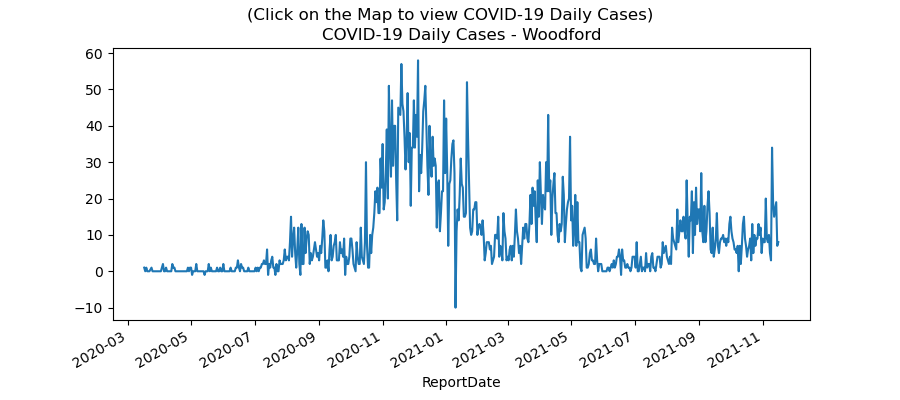

Map(center=[40.6, -89.6], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

In [20]:
def layer_on_click(**kwargs):
    global ax2
    ax2.cla() # clear previous plot
    county_name=kwargs["id"] # get the id (name) of the clicked county
    one_county = df[df["CountyName"]==county_name].set_index("ReportDate") # extract data for this county
    one_county.CasesChange.plot(ax=ax2, title='COVID-19 Daily Cases - {}'.format(county_name)) # plot time series

fig2, ax2 = plt.subplots(1,1, figsize=(9,4))
fig2.suptitle("(Click on the Map to view COVID-19 Daily Cases)")
layer.on_click(layer_on_click) # monitor mouse click event on the layer
map

## The End